In [248]:
%pylab inline
import numpy as np
import seaborn as sns
import pandas as pd
from metasense.epa import data as epa_data
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cross_validation import train_test_split
from sklearn.gaussian_process import GaussianProcess
from datetime import datetime
from IPython.display import HTML, Javascript, display
import GPy
from tqdm import tqdm
sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


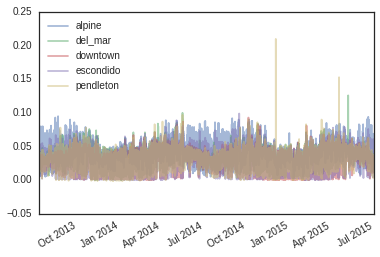

In [264]:
data = epa_data.load_pandas('../data')
ozone_data = data['ozone'].dropna(thresh=15000, axis=1)
ozone_data = ozone_data.fillna(ozone_data.mean())
ozone_data.plot(alpha=0.5);
train, test = ozone_data.loc['2014-01-01 00:00:00':'2014-12-31 23:59:59'], ozone_data.loc['2015-01-01 00:00:00':]

In [380]:
def convert_to_hours(data, hour_to_train, to_predict):
    X, y = [], []
    predict_row = []
    train_row = []
    adding = False
    for date, row in data.iterrows():
        date = date.to_datetime()
        if adding:
            predict_row.append(row.tolist()[to_predict])
        if date.hour == hour_to_train:
            if adding:
                y.append(predict_row)
            else:
                adding = True
            X.append(row.tolist())
            predict_row = []
            train_row = []
            adding = True
    X = X[:-1]
    return np.array(X), np.array(y)

def benchmark_hours(to_predict, dataset, num_hours=1):
    best_hours = (None, float('inf'), None)
    hour_scores = {}
    for possible_hour in tqdm(xrange(24)):
        Xtrain, ytrain = convert_to_hours(train, possible_hour, to_predict)
        #model = Lasso(alpha=0.00001)
        model = LinearRegression()
        model.fit(Xtrain, ytrain)
        ypred = model.predict(Xtrain)

        #kernel = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=.1)
        #model = GPy.models.GPRegression(Xtrain, ytrain, kernel)
        #ypred = model.predict(Xtrain)[0]
        score = sum((ypred.flatten() - ytrain.flatten()) ** 2)
        hour_scores[possible_hour] = score
        if score < best_hours[1]:
            best_hours = (possible_hour, score, model)
    model = best_hours[2]
    Xtest, ytest = convert_to_hours(dataset, best_hours[0], to_predict)
    ypred = model.predict(Xtest)
    plot(ypred.flatten()[:500], alpha=0.5)
    plot(ytest.flatten()[:500], alpha=0.5)
    return sum((ypred.flatten() - ytest.flatten()) ** 2), hour_scores, best_hours

0.255403807624


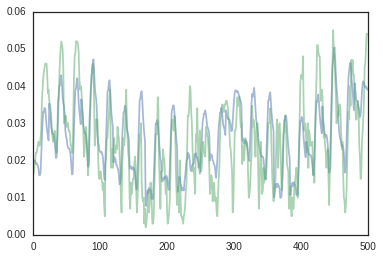

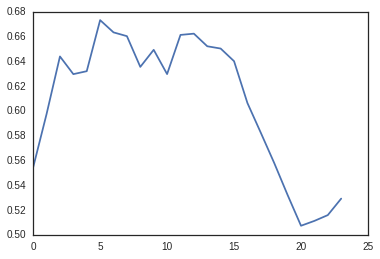

In [381]:
score, hour_scores, best_hours = benchmark_hours(1, test)
figure()
plot([a[1] for a in sorted(hour_scores.items(), key=lambda x: x[0])])
print score

In [382]:
sum(best_hours[2].coef_ == 0, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0])

In [296]:
Xtrain, ytrain = convert_to_hours(train, 20, 1)

In [299]:
ytrain.shape

(364, 24)